In [2]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym

import os

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

# os.environ["SDL_VIDEODRIVER"] = "dummy"


def eval_agent(agent, env, n_sim=5):
    """
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done:
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)


class ConvNet(nn.Module):
    def __init__(self, grid_size, num_features, hidden_size, n_actions):
        super(ConvNet, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(num_features, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),  # Dropout après pooling
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),  # Dropout après pooling
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        conv_out_size = self._get_conv_out(grid_size)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout dans la couche dense
            nn.Linear(hidden_size, n_actions),
        )

    def _get_conv_out(self, grid_size):
        out = self.conv_net(torch.zeros(1, *grid_size))
        return int(np.prod(out.size()))

    def forward(self, x):
        x = self.conv_net(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        return self.fc(x)


class DQN:
    def __init__(
        self,
        env,
        action_space,
        observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate,
        hidden_size,
    ):
        self.env = env
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = (
            decrease_epsilon_factor  # larger -> more exploration
        )
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.hidden_size = hidden_size

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        # Convert numpy arrays or lists to tensors and ensure they are floats
        action_tensor = torch.tensor([[action]], dtype=torch.int64)
        reward_tensor = torch.tensor([reward], dtype=torch.float32)
        terminated_tensor = torch.tensor([terminated], dtype=torch.int64)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        # Store transition in the replay buffer
        self.buffer.push(
            state_tensor,
            action_tensor,
            reward_tensor,
            terminated_tensor,
            next_state_tensor,
        )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = (
            tuple([torch.cat(data) for data in zip(*transitions)])
        )

        values = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1)  # Gradient clipping
        self.optimizer.step()

        # Soft update the target network
        for target_param, local_param in zip(
            self.target_net.parameters(), self.q_net.parameters()
        ):
            target_param.data.copy_(
                0.995 * target_param.data + 0.005 * local_param.data
            )

        self.scheduler.step()  # Step through the scheduler

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.detach().numpy()

    def get_action(self, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.get_q(state))

    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor)  # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)

    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
            np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        )

    def reset(self):
        # obs_size = self.observation_space.shape[0]
        obs_size = np.prod(self.env.observation_space.shape)
        n_actions = self.action_space.n
        grid_size = self.env.observation_space.shape
        num_features = 7

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net = ConvNet(grid_size, num_features, self.hidden_size, n_actions)
        self.target_net = ConvNet(grid_size, num_features, self.hidden_size, n_actions)
        self.target_net.load_state_dict(
            self.q_net.state_dict()
        )  # Initialize target net
        self.target_net.eval()  # Set target net to eval mode

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.q_net.parameters(), lr=self.learning_rate, weight_decay=1e-5
        )
        self.scheduler = StepLR(
            self.optimizer, step_size=100, gamma=0.99
        )  # Learning rate scheduler

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

    def save(self, filename):
        """
        Save the current model parameters to the specified file.
        """
        torch.save(
            {
                "q_net_state_dict": self.q_net.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "scheduler_state_dict": self.scheduler.state_dict(),
                "epsilon": self.epsilon,
                "n_steps": self.n_steps,
                "n_eps": self.n_eps,
            },
            filename,
        )
        print(f"Model saved to {filename}")

    def load(self, filename):
        """
        Load model parameters from the specified file.
        """
        checkpoint = torch.load(filename)
        self.q_net.load_state_dict(checkpoint["q_net_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        self.epsilon = checkpoint["epsilon"]
        self.n_steps = checkpoint["n_steps"]
        self.n_eps = checkpoint["n_eps"]
        self.target_net.load_state_dict(self.q_net.state_dict())
        print(f"Model loaded from {filename}")

In [3]:
def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if (ep + 1) % eval_every == 0:
            rewards = eval_agent(agent, env)
            print("episode =", ep + 1, ", reward = ", np.mean(rewards))
            if np.mean(rewards) >= reward_threshold:
                break

    return losses

episode = 10 , reward =  2.152208310798705
episode = 20 , reward =  0.9230212425188663
episode = 30 , reward =  2.5077147137911653
episode = 40 , reward =  2.462094082092948
episode = 50 , reward =  2.768344082092948
episode = 60 , reward =  0.9475319174234389
episode = 70 , reward =  2.218344082092948
episode = 80 , reward =  2.6009783622181066
episode = 90 , reward =  1.4
episode = 100 , reward =  1.821135996073221
episode = 110 , reward =  3.4286121590559704
episode = 120 , reward =  3.819728362218106
episode = 130 , reward =  2.8393939125603613
episode = 140 , reward =  2.680844082092948
episode = 150 , reward =  1.5849335055080211
episode = 160 , reward =  2.054753001275032
episode = 170 , reward =  1.8125
episode = 180 , reward =  2.349594082092948
episode = 190 , reward =  1.7907669229061227
episode = 200 , reward =  1.405844082092948
episode = 210 , reward =  3.082371525607529
episode = 220 , reward =  2.81875
episode = 230 , reward =  2.9704084392600065
episode = 240 , reward 

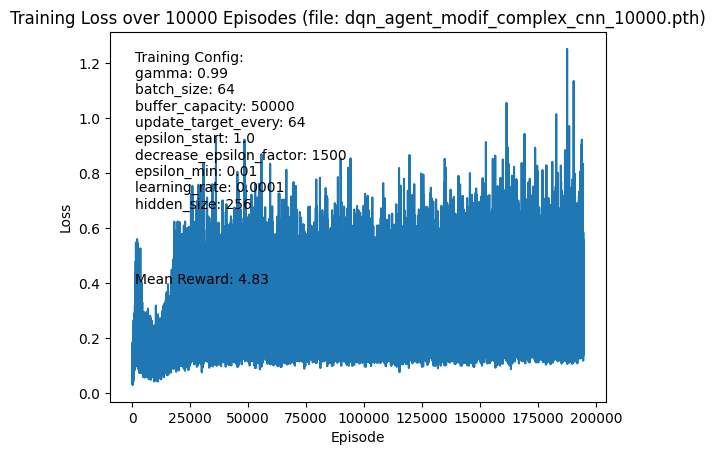

In [5]:
# Adjusted environment initialization for "highway-fast-v0"
import gymnasium as gym
from gymnasium import spaces
from config import config

# Configure and create the environment
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
action_space = env.action_space
observation_space = env.observation_space

# Update the DQN Agent initialization with the new action and observation spaces
# Note: Ensure that observation dimensions are correctly handled within your DQN architecture.
# This might require adjustments depending on how the "OccupancyGrid" observations are structured.

# Hyperparameters might need adjustment based on the new environment dynamics.
# gamma = 0.99
# batch_size = 128
# buffer_capacity = 20_000
# update_target_every = 32
# epsilon_start = 0.9
# decrease_epsilon_factor = 1500
# epsilon_min = 0.01
# learning_rate = 1e-4
# hidden_size = 256

# gamma = 0.99
# batch_size = 64
# buffer_capacity = 10000
# update_target_every = 1000
# epsilon_start = 1.0
# decrease_epsilon_factor = 10000
# epsilon_min = 0.1
# learning_rate = 1e-4
# hidden_size = 256

gamma = 0.99
batch_size = 64
buffer_capacity = 50000
update_target_every = 64
epsilon_start = 1.0
decrease_epsilon_factor = 1500
epsilon_min = 0.01
learning_rate = 1e-4
hidden_size = 256


n_actions = env.action_space.n

# When you instantiate the DQN agent:
agent = DQN(
    env,
    action_space,
    observation_space,
    gamma,
    batch_size,
    buffer_capacity,
    update_target_every,
    epsilon_start,
    decrease_epsilon_factor,
    epsilon_min,
    learning_rate,
    hidden_size,
)

# Training might need adjustments, especially evaluation metrics and thresholding for success.
N_episodes = 10000
file_name = "dqn_agent_modif_complex_cnn_10000.pth"

# Proceed with the adjusted training function
# Ensure that your training and evaluation routines properly handle the updated environment observations and actions.
losses = train(env, agent, N_episodes)
agent.save(file_name)

training_config = {
    "gamma": gamma,
    "batch_size": batch_size,
    "buffer_capacity": buffer_capacity,
    "update_target_every": update_target_every,
    "epsilon_start": epsilon_start,
    "decrease_epsilon_factor": decrease_epsilon_factor,
    "epsilon_min": epsilon_min,
    "learning_rate": learning_rate,
    "hidden_size": hidden_size,
}
rewards = eval_agent(agent, env, 50)
print("")
print("mean reward after training = ", np.mean(rewards))

plt.plot(losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title(f"Training Loss over {N_episodes} Episodes (file: {file_name})")

# Add training config
training_config_text = "\n".join(
    [f"{key}: {value}" for key, value in training_config.items()]
)
config_text = f"Training Config:\n{training_config_text}"
plt.text(
    0.05,
    0.95,
    config_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
)

# Add mean reward
mean_reward = np.mean(rewards)
reward_text = f"Mean Reward: {mean_reward:.2f}"
plt.text(
    0.05,
    0.35,
    reward_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
)


plt.show()

In [ ]:
# Load the trained agent
from config import config
import gymnasium as gym
from gymnasium import spaces

env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
action_space = env.action_space
observation_space = env.observation_space

# Update the DQN Agent initialization with the new action and observation spaces
# Note: Ensure that observation dimensions are correctly handled within your DQN architecture.
# This might require adjustments depending on how the "OccupancyGrid" observations are structured.

# Hyperparameters might need adjustment based on the new environment dynamics.
gamma = 0.99
batch_size = 128
buffer_capacity = 20_000
update_target_every = 32
epsilon_start = 0.9
decrease_epsilon_factor = 1500
epsilon_min = 0.01
learning_rate = 1e-4
hidden_size = 256
n_actions = env.action_space.n

# When you instantiate the DQN agent:
agent = DQN(
    env,
    action_space,
    observation_space,
    gamma,
    batch_size,
    buffer_capacity,
    update_target_every,
    epsilon_start,
    decrease_epsilon_factor,
    epsilon_min,
    learning_rate,
    hidden_size,
)

agent.load("dqn_agent_modif_noOffRoad_1000.pth")

Model loaded from dqn_agent_modif_noOffRoad_1000.pth


In [7]:
# Evaluate the final policy
rewards = eval_agent(agent, env, 50)
print("")
print("mean reward after training = ", np.mean(rewards))


mean reward after training =  9.0414462


2024-04-19 19:12:52.290 Python[97197:1330509] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


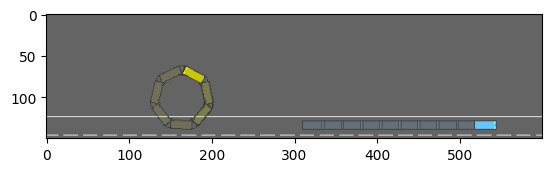

In [12]:
# env = gym.make('highway-v0', render_mode='rgb_array')
state = env.reset()
for _ in range(1):
    state, _ = env.reset()
    # action = env.action_type.actions_indexes["IDLE"]
    # print(state)
    action = agent.get_action(state)
    # print(action)
    state, reward, done, _, _ = env.step(action)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
plt.show()

In [6]:
while True:
    done = truncated = False
    obs, _ = env.reset()            
    while not (done or truncated):
        action = agent.get_action(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()

2024-04-22 00:52:05.598 Python[70792:3120604] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


AttributeError: 'NoneType' object has no attribute 'get_image'